In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

/ssd_scratch/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
casestore = dict()

In [3]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [

    # dict(name="base", id="x4a1-base_mc", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="new-defaults", id="x4a2-new_default_bcs", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="tn_30eV", id="x4a3-tn_30ev", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="fastbase", id="x5a1-quicker_base", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="base", id="x5a1b-fluxes_branch", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="free", id="x5a1c-free_edge_ion_P_N", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    dict(name="dev", id="x5a1d-custom_boundary", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
]


for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                            double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                            unnormalise_geom = case["unnormalise_geom"], squeeze = False)


CHECK: Total domain volume is 1.607E+00 [m3]


## Find saved variables

In [ ]:
ds = casestore["dev"].ds
ds.data_vars

# Radial profiles for BC check

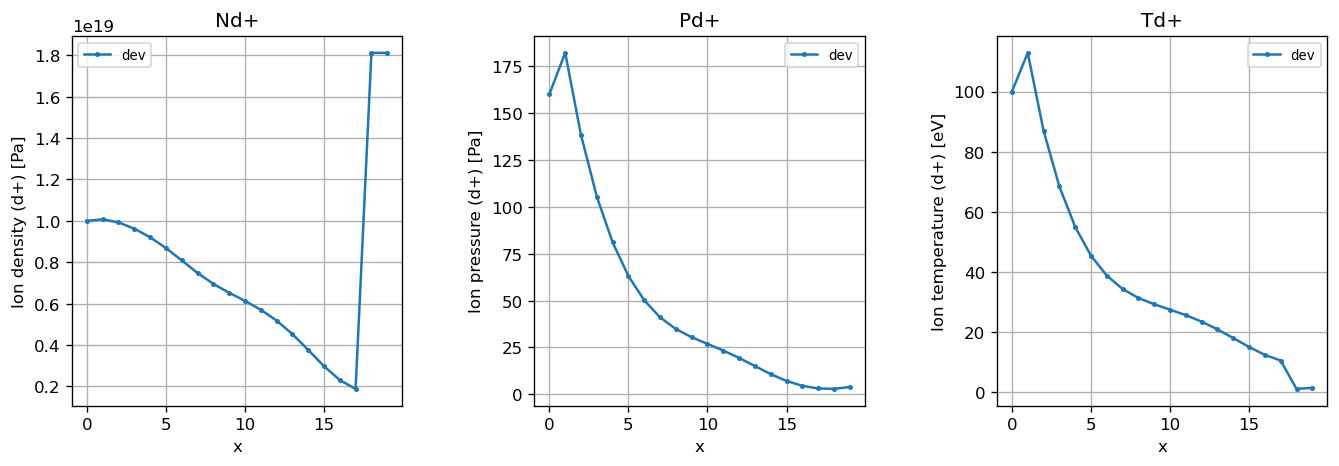

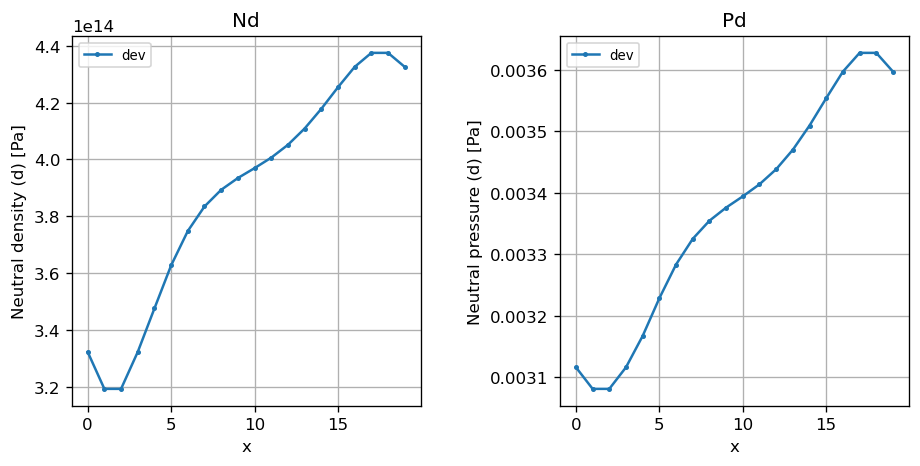

In [38]:
def plot(params):

    fig, axes = plt.subplots(1,len(params), figsize=(4.5*len(params),4), dpi=120)
    fig.subplots_adjust(wspace = 0.4)

    for i, param in enumerate(params):
        for casename in casestore:
            ds = casestore[casename].ds.isel(t=-1)
            omp = ds.hermesm.select_region("outer_midplane_a")

            (omp[param]).plot(ax = axes[i], marker = "o", label = casename, ms = 2)
            
            # if omp[param].max()/omp[param].min() > 10:
            #     axes[i].set_yscale("log")
        axes[i].grid()
        axes[i].set_title(param)
        axes[i].legend(fontsize = 8)
   
# plot(["Nd", "Pd", "Td", "Dnnd"])  
plot(["Nd+", "Pd+", "Td+"])   
plot(["Nd", "Pd"])


Text(0.5, 1.0, 'Nd+ decay BC test on OMP')

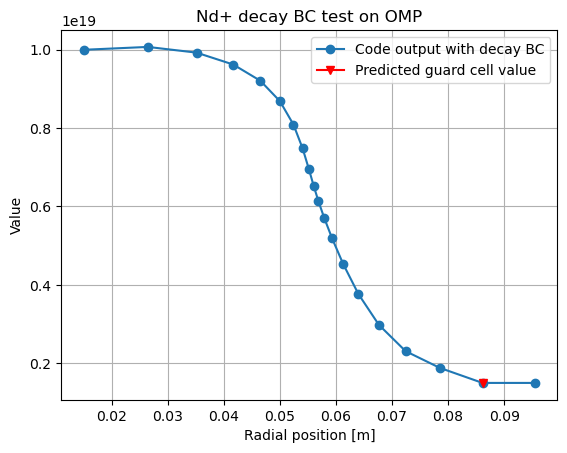

In [5]:
fig, ax = plt.subplots()

ds = casestore["dev"].ds.isel(t=-1)
omp = ds.hermesm.select_region("outer_midplane_a")
last = omp.isel(x=-3)
guard = omp.isel(x=-2)
distance = 0.5 * (last["dr"] + guard["dr"])
decay_length = 0.03
extrapolation = last["Nd+"] * np.exp(-1 * distance / decay_length).values

dr = omp["dx"].values / np.sqrt(omp["g11"].values)
radial = dr.cumsum()

ax.plot(radial, omp["Nd+"], marker = "o", label = "Code output with decay BC")
ax.plot(radial[-2], extrapolation, marker = "v", color = "r", label = "Predicted guard cell value")
ax.set_xlabel("Radial position [m]")
ax.set_ylabel("Value")
ax.grid()
ax.legend()
ax.set_title("Nd+ decay BC test on OMP")

In [10]:
ds.metadata["rho_s0"]

0.0010217477552952484

# Dummy profile decay test

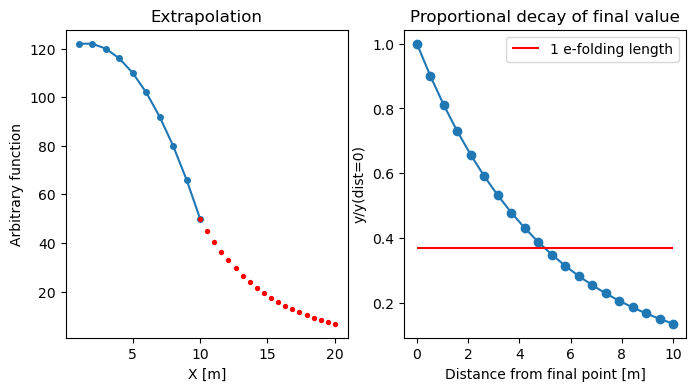

In [33]:
x = np.linspace(1,10,10)
x2 = np.linspace(10,20,20)

y = x*3 - x**2 + 120

lastx = x[-1]
dist = 1
length = 5
y2 = y[-1]*np.exp(-(x2 -lastx)/length)
fig, axes = plt.subplots(1,2, figsize=(8,4))

ax = axes[0]; ax.set_title("Extrapolation")
ax.plot(x,y, marker = "o", ms = 4)
ax.scatter(x2, y2, color = "r", s = 8, zorder = 100)
ax.set_xlabel("X [m]")
ax.set_ylabel("Arbitrary function")

ax = axes[1]; ax.set_title("Proportional decay of final value")
ax.plot((x2-lastx), y2 / y[-1], marker = "o")
ax.hlines(y = 1/np.exp(1), xmin = (x2-lastx)[0], xmax = (x2-lastx)[-1], color = "red", label = "1 e-folding length")
ax.set_xlabel("Distance from final point [m]")
ax.set_ylabel("y/y(dist=0)")
ax.legend()

- g11 is (R*Bpol)**2
- So since dr = dx / (R*Bpol)
- Then dr = dx / sqrt(g11) 

[0.01504595 0.01140836 0.00868153 0.00654581 0.00483809 0.00347604
 0.00241679 0.00163481 0.0011177  0.00085983 0.0008475  0.001035
 0.00141003 0.00197116 0.00271707 0.00364794 0.00476853 0.00609353
 0.00762219 0.00933376]
[0.01504595 0.01140836 0.00868153 0.00654581 0.00483809 0.00347604
 0.00241679 0.00163481 0.0011177  0.00085983 0.0008475  0.001035
 0.00141003 0.00197116 0.00271707 0.00364794 0.00476853 0.00609353
 0.00762219 0.00933376]


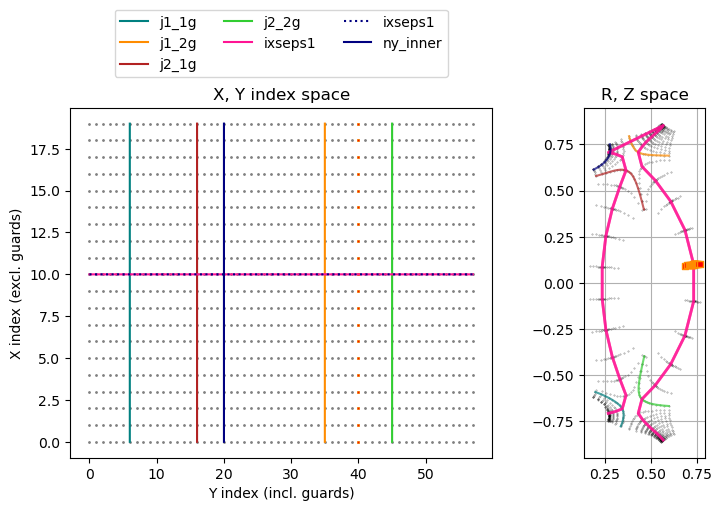

In [42]:
plot_selection(ds, ds.hermesm.select_region("outer_midplane_a"))

In [ ]:
toplot = dict()
# case_sel = ["fit_nsep3", "factor"]
case_sel = casestore.keys()
for casename in case_sel:
    toplot[casename] = casestore[casename].ds

lineplot(
    toplot,
    # params = ["Ne", "Td+", "Pd+", "NVd+"],
    params = ["Ne", "Td+", "Nd", "Td"],
    regions = ["field_line", "omp", "outer_lower"],
    # regions = ["omp"],
    scale = "log",
    dpi = 100
)

# Heat and particle balances

### Calculate

In [4]:
for name in casestore:
    casestore[name].ds = calculate_radial_fluxes(casestore[name].ds, force_neumann = False)
    casestore[name].ds = calculate_target_fluxes(casestore[name].ds)
    casestore[name].ds = calculate_heat_balance(casestore[name].ds)
    casestore[name].ds = calculate_particle_balance(casestore[name].ds)

In [5]:
for name in ["dev"]:
    print(name)
    ds = casestore[name].ds
    show_particle_balance_table(ds)
    # show_heat_balance_table(ds)


dev
---------------------------------------
PARTICLE BALANCE
---------------------------------------
Domain volume: 1.607e+00 [m3]
Particle imbalance: -1.820e+18 [s-1]
Particle imbalance as frac of core + source: -0.81%
---------------------------------------
Total fluxes in [s-1]:


,d+,d,total
source,0.00e+00,0.00e+00,0.00e+00
core,2.25e+20,0.00e+00,2.25e+20
sol,-7.38e+19,-0.00e+00,-7.38e+19
pfr,0.00e+00,0.00e+00,0.00e+00
targets,-3.05e+21,2.90e+21,-1.53e+20
iz,2.90e+21,-2.90e+21,0.00e+00
rec,-3.58e+17,3.58e+17,0.00e+00


# Manual flux calcs - validation

In [5]:
ds = casestore["dev"].ds.isel(t=-1)
m = ds.metadata

core = ds.hermesm.select_region("core_edge")
sol = ds.hermesm.select_region("sol_edge")
sol_guards = ds.hermesm.select_region("sol_edge_inner_guards")
pfr = ds.hermesm.select_region("pfr_edge")
domain = ds.hermesm.select_region("all_noguards").squeeze()
domain_noy = ds.hermesm.select_region("all_no_y_guards").squeeze()
domain_volume = domain["dv"].values.sum()

Pnorm = m["Nnorm"] * m["Tnorm"] * constants("q_e")
nfluxnorm =  (m["rho_s0"] * m["rho_s0"]**2 * m["Nnorm"] * m["Omega_ci"])
efluxnorm =  (m["rho_s0"] * m["rho_s0"]**2 * Pnorm * m["Omega_ci"])   # W
nsourcenorm = (m["Nnorm"] * m["Omega_ci"])
esourcenorm = (Pnorm * m["Omega_ci"]) 

In [5]:
pf_rec_total = ((domain["Sd_target_recycle"] * nsourcenorm) * domain["dv"]).values.sum()


print(pf_rec_total)

3.122204801044811e+21


In [6]:
pf_rec_sol = ((domain["Sd_sol_recycle"] * nsourcenorm)* domain["dv"]).values.sum()
hf_rec_sol = ((domain["Ed_sol_recycle"] * esourcenorm) * domain["dv"]).values.sum()

print(pf_rec_sol)
print(hf_rec_sol)

7.384019150539778e+19
35.491508533881266


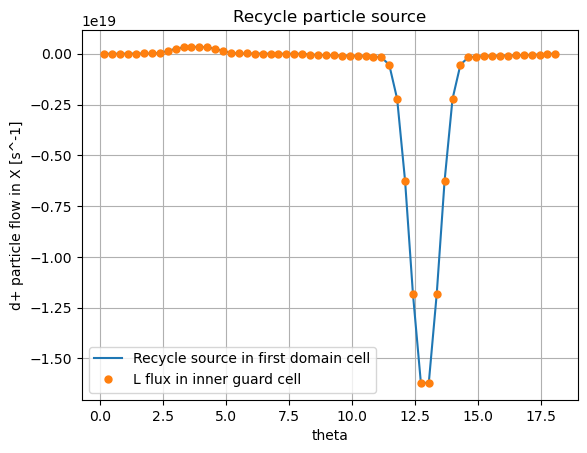

In [23]:
(ds["Sd_sol_recycle"].isel(x=-3) * nsourcenorm * ds["dv"].isel(x=-3) *-1).plot(label = "Recycle source in first domain cell")
(ds["ParticleFlow_d+_xlow"].isel(x=-2) * nfluxnorm).plot(label = "L flux in inner guard cell", lw = 0, marker = "o", ms = 5)
plt.legend()
plt.title("Recycle particle source")
plt.grid()
# ds["Sd_target_recycle"].isel(x=-3).plot()

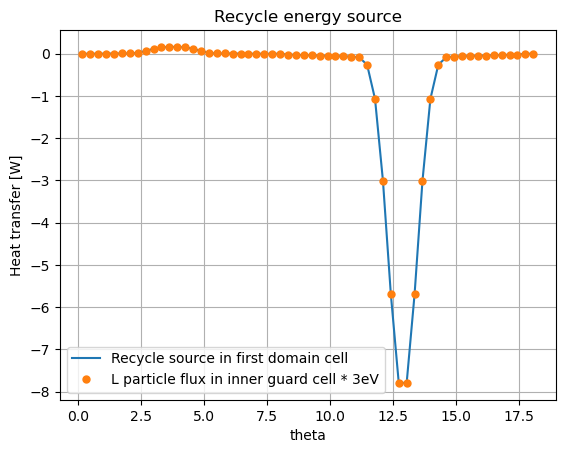

In [28]:
(ds["Ed_sol_recycle"].isel(x=-3) * esourcenorm * ds["dv"].isel(x=-3) *-1).plot(label = "Recycle source in first domain cell")
(ds["ParticleFlow_d+_xlow"].isel(x=-2) * nfluxnorm * 3 * constants("q_e")).plot(label = "L particle flux in inner guard cell * 3eV", lw = 0, marker = "o", ms = 5)
plt.legend()
plt.title("Recycle energy source")
plt.ylabel("Heat transfer [W]")
plt.grid()
# ds["Sd_target_recycle"].isel(x=-3).plot()

# SOL edge gradients

Text(0.5, 1.0, '(last - guard)/last (+ve = out of domain)')

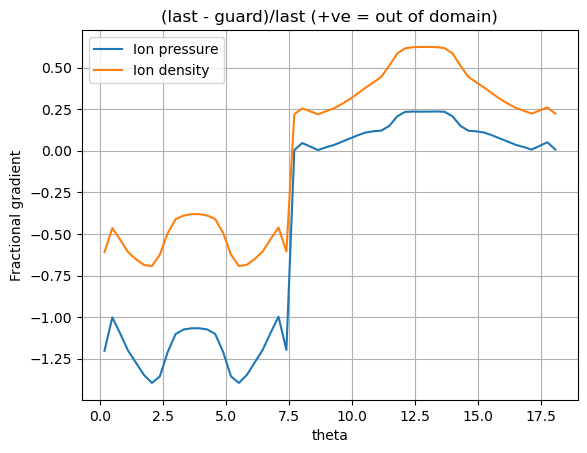

In [19]:
((ds["Pd+"].isel(x=-3) - ds["Pd+"].isel(x=-2)) /  ds["Pd+"].isel(x=-3)).plot(label = "Ion pressure")
((ds["Nd+"].isel(x=-3) - ds["Nd+"].isel(x=-2)) /  ds["Nd+"].isel(x=-3)).plot(label = "Ion density")
# (ds["Pd+"].isel(x=-2) *-1).plot(label = "recycle")
# (ds["ParticleFlow_d+_xlow"].isel(x=-2) * nfluxnorm).plot(label = "flux")
plt.legend()
plt.grid()
plt.ylabel("Fractional gradient")
plt.title("(last - guard)/last (+ve = out of domain)")
# ds["Sd_target_recycle"].isel(x=-3).plot()

In [ ]:
plot_selection(ds, domain_noy)

In [7]:
domain_noy.isel(x=-2)["ParticleFlow_d+_xlow"].values.sum() * nfluxnorm

-7.384019150539778e+19

In [8]:
domain_noy.isel(x=-2)["ParticleFlow_d+_xlow"].values.sum() * nfluxnorm * (3 * constants("q_e"))

-35.49150853388127

In [10]:
species = "d+"
core_flux = core[f"pf_perp_diff_L_{species}"].sum("theta").squeeze().values
sol_flux = sol_guards[f"pf_perp_diff_L_{species}"].sum("theta").squeeze().values * -1
pfr_flux = pfr[f"pf_perp_diff_L_{species}"].sum("theta").squeeze().values
target_flux = ds["pf_int_targets_d+"].values
recycle_flux = (domain["Sd_target_recycle"]* (m["Nnorm"] * m["Omega_ci"]) * domain["dv"]).sum().values 

print(f"Core flux: {core_flux:.2e}")
print(f"SOL flux: {sol_flux:.2e}")
print(f"PFR flux: {pfr_flux:.2e}")
print(f"Target flux: {target_flux:.2e}")
print(f"Recycle flux: {recycle_flux:.2e}")

Core flux: 2.25e+20
SOL flux: -7.38e+19
PFR flux: 0.00e+00
Target flux: -3.05e+21
Recycle flux: 2.73e+21


In [46]:
ds["pf_int_targets_d+"].values[0]

-3.050598318477588e+21

In [39]:
frecycle = 0.95
total = 0
for loc in ["inner_lower_target", "inner_upper_target", "outer_upper_target", "outer_lower_target"]:
    target = ds.hermesm.select_region(loc)
    recycle_source = (target["Sd_src_recycle"] * (m["Nnorm"] * m["Omega_ci"] * target["dv"])).sum().values 
    total += recycle_source 
    print(f"{loc}: {recycle_source:.2e}")
    

print(f"Recycle flux: {total:.2e}")

inner_lower_target: 3.57e+20
inner_upper_target: 3.58e+20
outer_upper_target: 1.09e+21
outer_lower_target: 1.09e+21
Recycle flux: 2.90e+21


In [20]:
%matplotlib widget

/ssd_scratch/scripts/sdtools/hermes3/accessors.py:8: AccessorRegistrationWarning: registration of accessor <class 'hermes3.accessors.HermesDataArrayAccessor'> under name 'hermesm' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  class HermesDataArrayAccessor(BoutDataArrayAccessor):
/ssd_scratch/scripts/sdtools/hermes3/accessors.py:45: AccessorRegistrationWarning: registration of accessor <class 'hermes3.accessors.HermesDatasetAccessor'> under name 'hermesm' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class HermesDatasetAccessor(BoutDatasetAccessor):


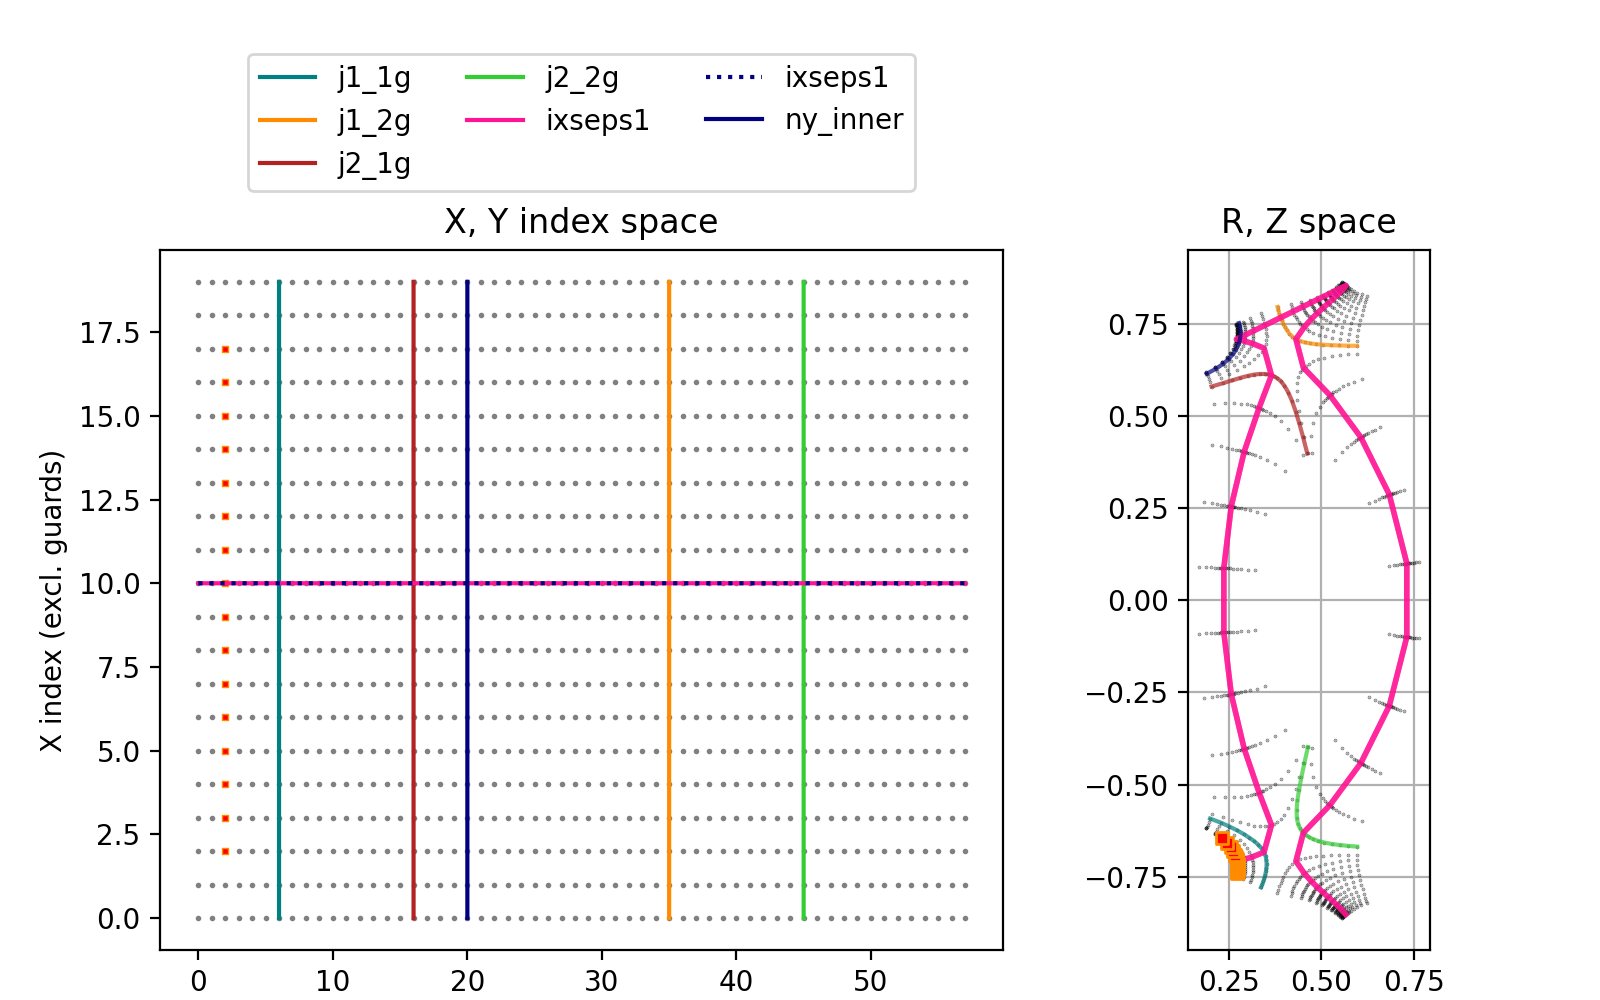

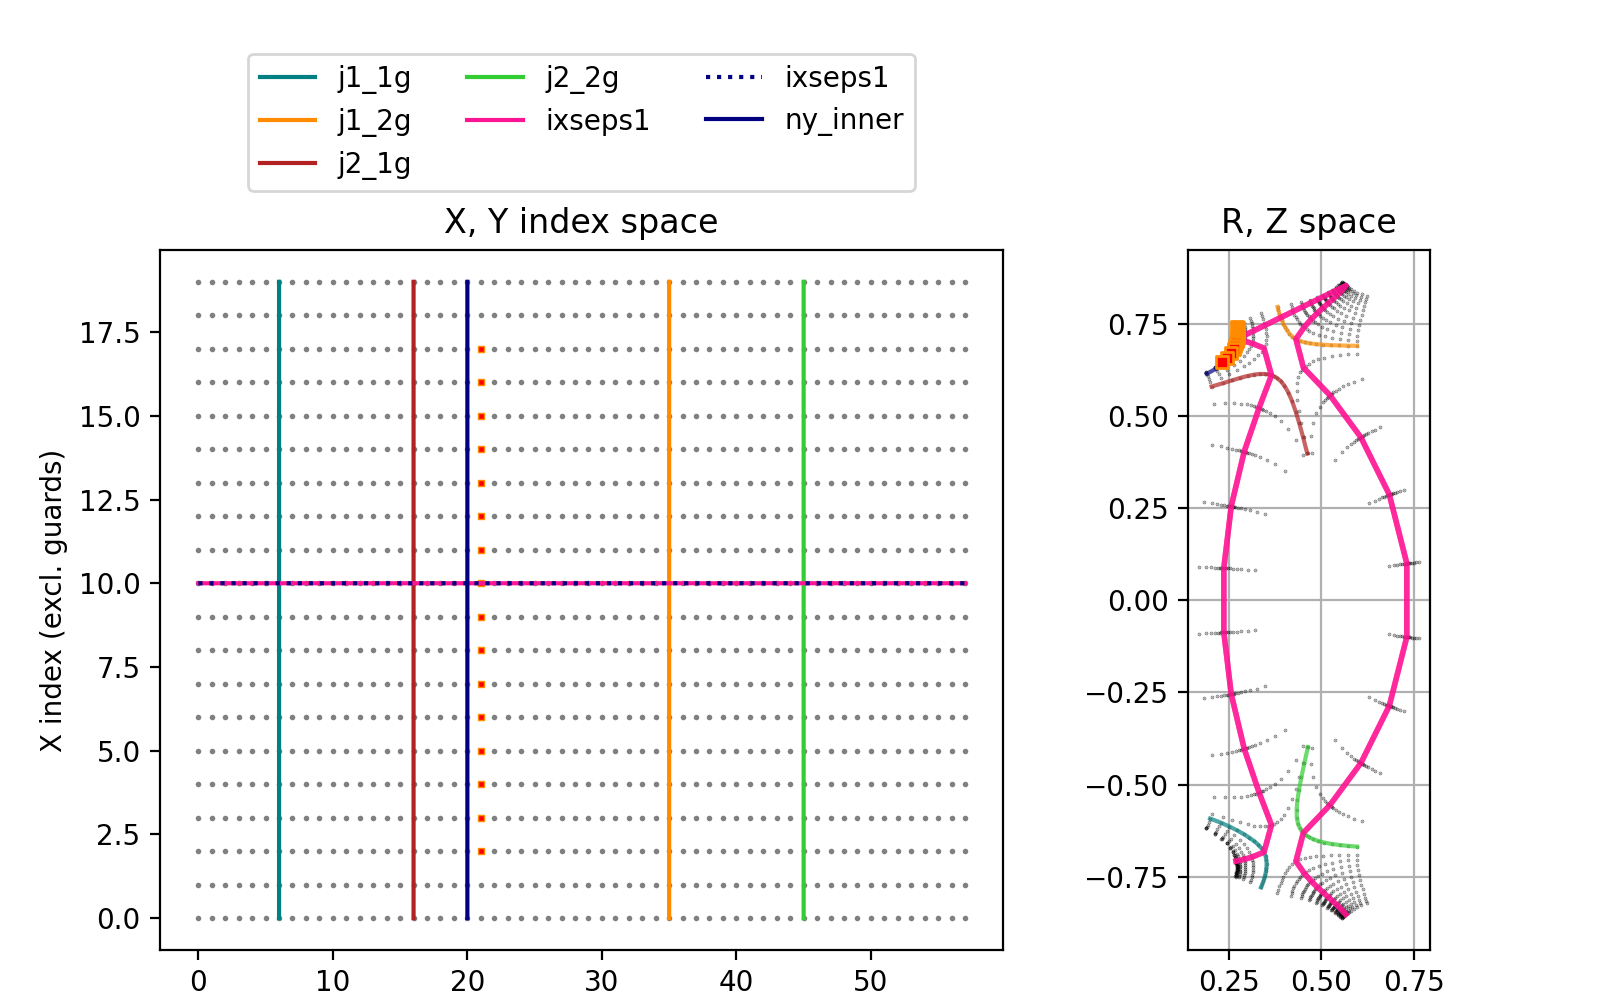

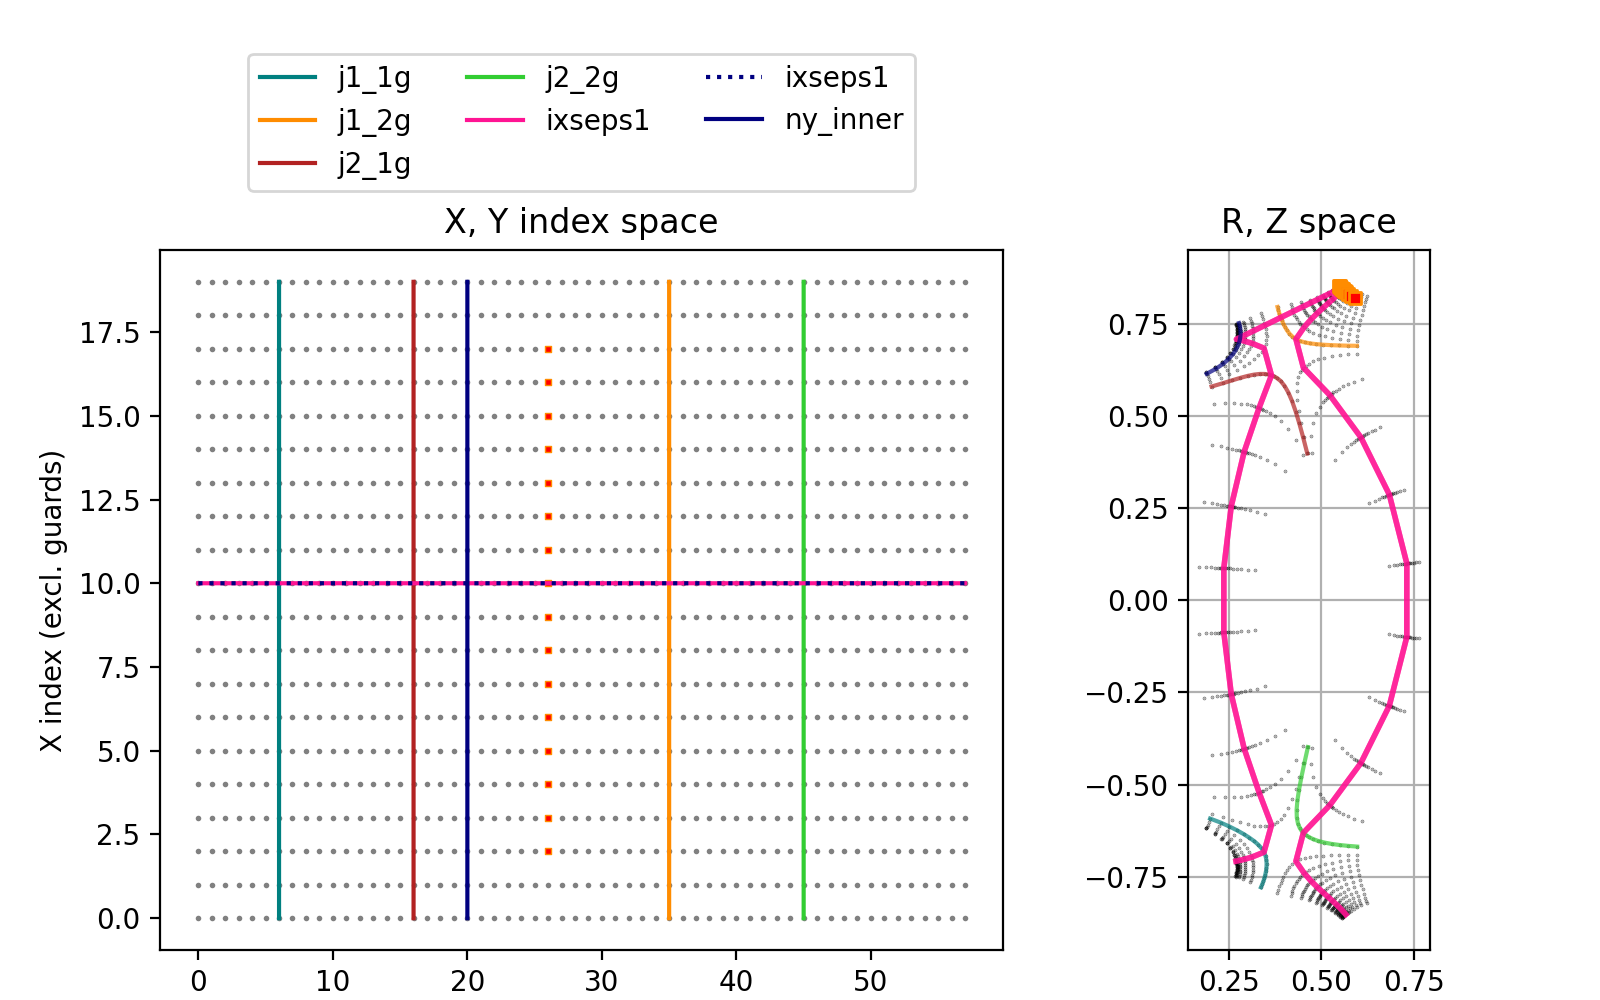

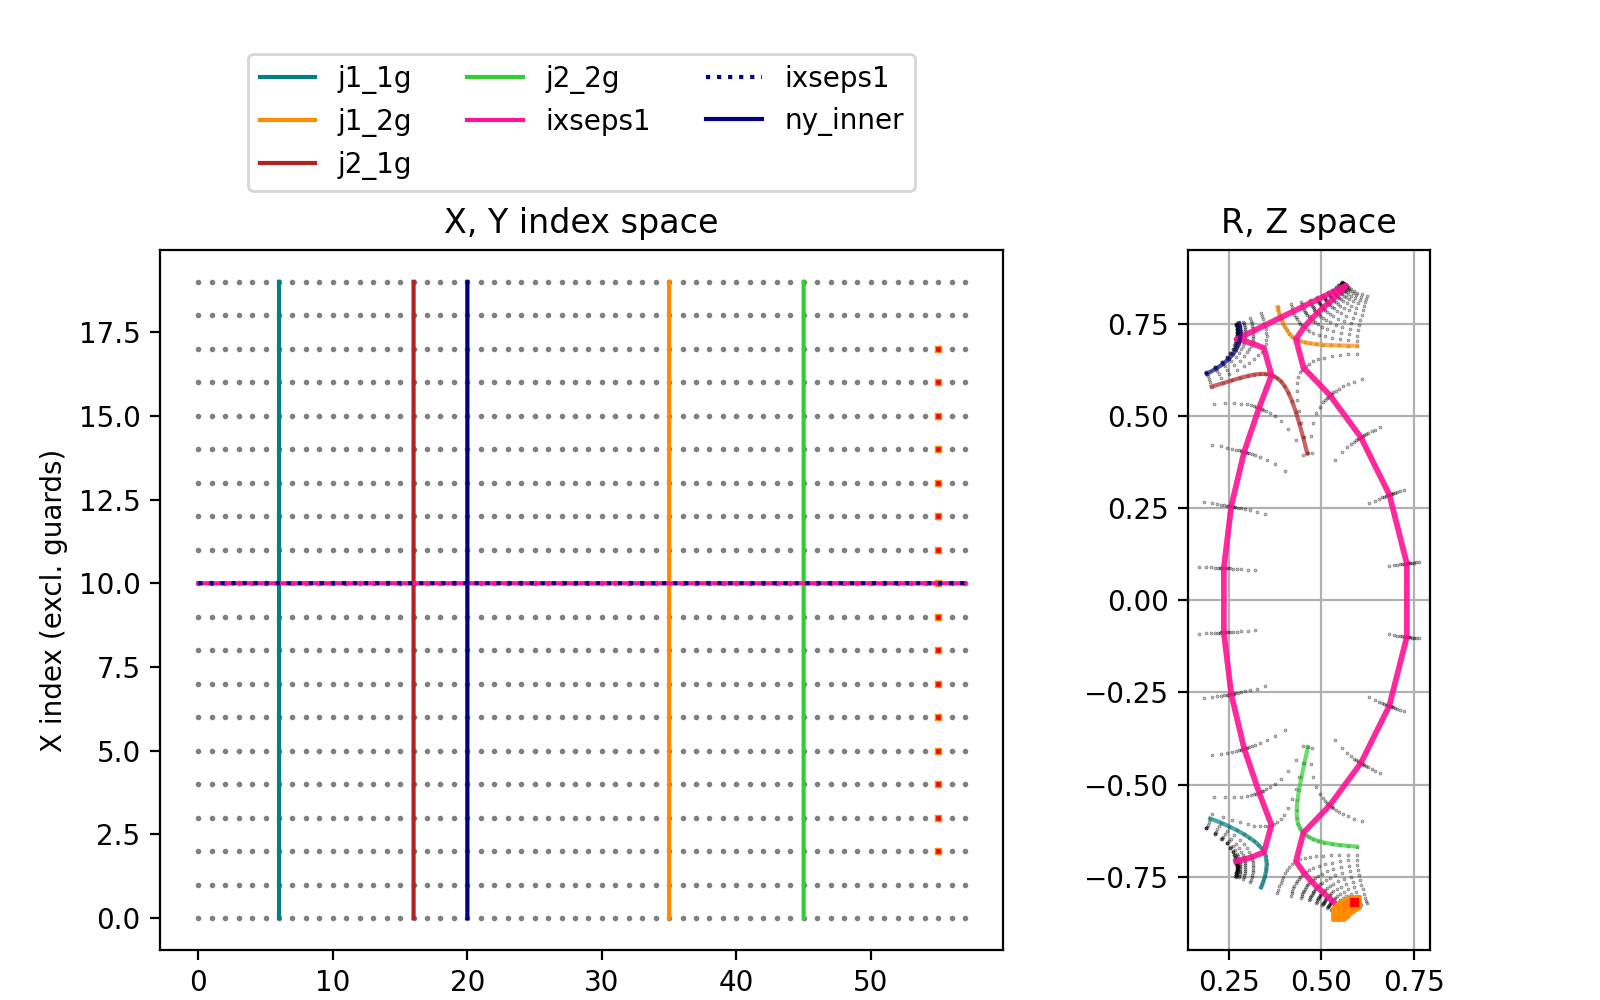

In [38]:
plt.close("all")
for loc in ["inner_lower_target", "inner_upper_target", "outer_upper_target", "outer_lower_target"]:
    plot_selection(ds, ds.hermesm.select_region(loc), dpi = 200)

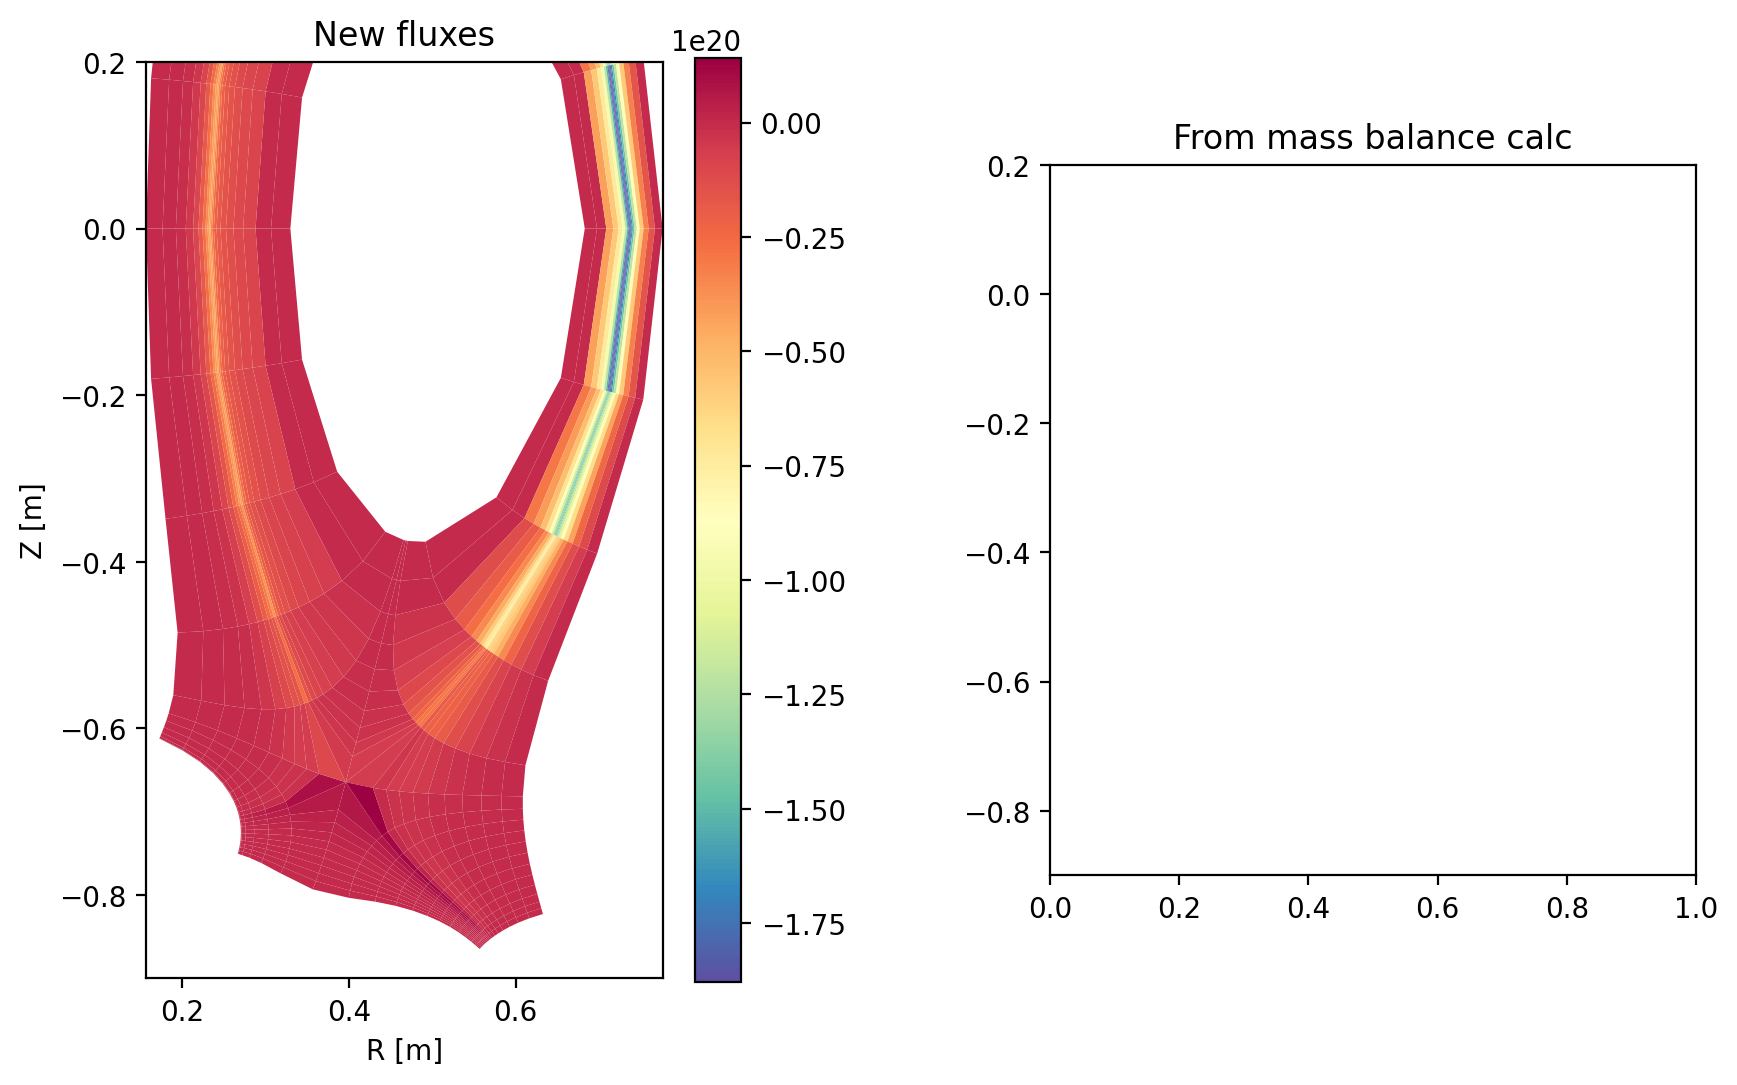

In [9]:
fig, axes = plt.subplots( 1, 2, dpi = 200, figsize = (10,6))

fig.subplots_adjust(wspace=0.4)
ds = casestore["dev"].ds#.isel(t=-1)
m = ds.metadata
ax = axes[0]
(ds["ParticleFlow_d+_xlow"] * (m["rho_s0"] * m["rho_s0"]**2 * m["Nnorm"] * m["Omega_ci"])).bout.polygon(ax = axes[0],antialias = True, cmap = "Spectral_r")

ax = axes[1]
# (ds["pf_perp_diff_L_d+"]*-1).bout.polygon(ax = axes[1],antialias = True, cmap = "Spectral_r")

ax.set_aspect("equal")

axes[0].set_title("New fluxes")
axes[1].set_title("From mass balance calc")

for ax in axes:
    ax.set_ylim(-0.9, 0.2)

In [20]:
%matplotlib widget

In [27]:
from hermes3.accessors import *

/ssd_scratch/scripts/sdtools/hermes3/accessors.py:8: AccessorRegistrationWarning: registration of accessor <class 'hermes3.accessors.HermesDataArrayAccessor'> under name 'hermesm' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  class HermesDataArrayAccessor(BoutDataArrayAccessor):
/ssd_scratch/scripts/sdtools/hermes3/accessors.py:45: AccessorRegistrationWarning: registration of accessor <class 'hermes3.accessors.HermesDatasetAccessor'> under name 'hermesm' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class HermesDatasetAccessor(BoutDatasetAccessor):


/ssd_scratch/scripts/sdtools/hermes3/accessors.py:8: AccessorRegistrationWarning: registration of accessor <class 'hermes3.accessors.HermesDataArrayAccessor'> under name 'hermesm' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  class HermesDataArrayAccessor(BoutDataArrayAccessor):
/ssd_scratch/scripts/sdtools/hermes3/accessors.py:45: AccessorRegistrationWarning: registration of accessor <class 'hermes3.accessors.HermesDatasetAccessor'> under name 'hermesm' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class HermesDatasetAccessor(BoutDatasetAccessor):


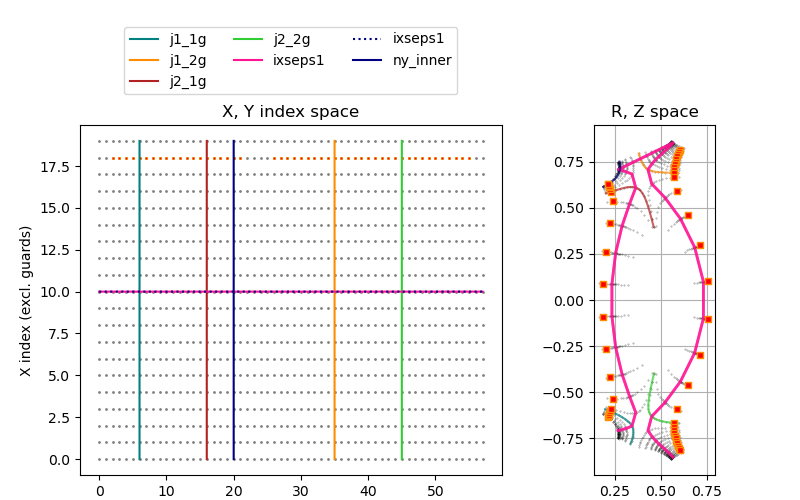

In [50]:
sol = ds.hermesm.select_region("sol_edge_inner_guards")
plot_selection(ds, sol)

---------------------------------------
HEAT BALANCE
---------------------------------------
Domain volume: 1.607e+00 [m3]
Power in: 3.717 [MW]
Power out: -3.875 [MW]
Power imbalance: -0.158 [MW]
Power imbalance as frac of core + source: -4.26%
---------------------------------------
Total fluxes in [MW]:


,d,e,d+,total
source,0.00,0.00,0.00,0.00
core,0.00,1.75,1.97,3.72
sol,-0.04,-0.00,0.00,-0.04
pfr,0.00,0.00,-0.00,-0.00
targets,0.00,-1.50,-1.86,-3.36
rad_ex,nan,-0.47,nan,-0.47
rad_rec,nan,-0.00,nan,-0.00


<class 'list'>
<class 'list'>


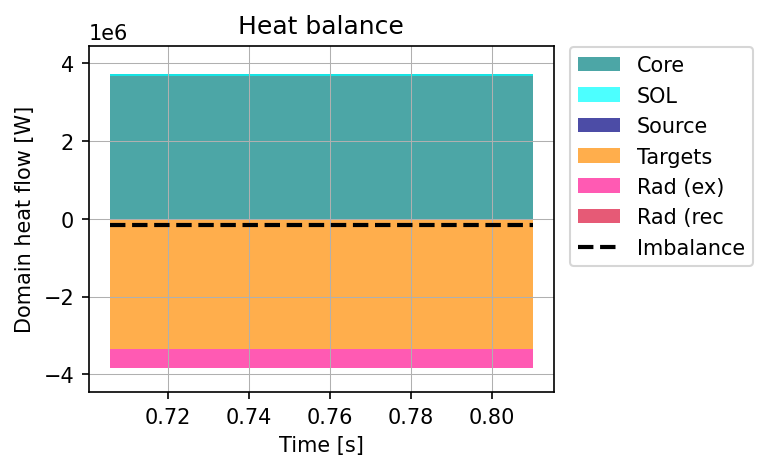

In [20]:
# import warnings
# warnings.simplefilter('ignore', RuntimeWarning)
show_heat_balance_table(ds)
plot_heat_balance(ds)

```
for(int ix=0; ix < mesh->LocalNx ; ix++){
      for(int iy=0; iy < mesh->LocalNy ; iy++){
          for(int iz=0; iz < mesh->LocalNz; iz++){

            // output << "("" << ix << "Y:" << iy << "Z:" << iz << "T:" << Tn(ix, iy, iz) << "  ";
            std::string string_count = std::string("(") + std::to_string(ix) + std::string(",") + std::to_string(iy)+ std::string(",") + std::to_string(iz) + std::string(")");
            output << string_count + std::string(": ") + std::to_string(Tn(ix,iy,iz)) + std::string("; ");
```

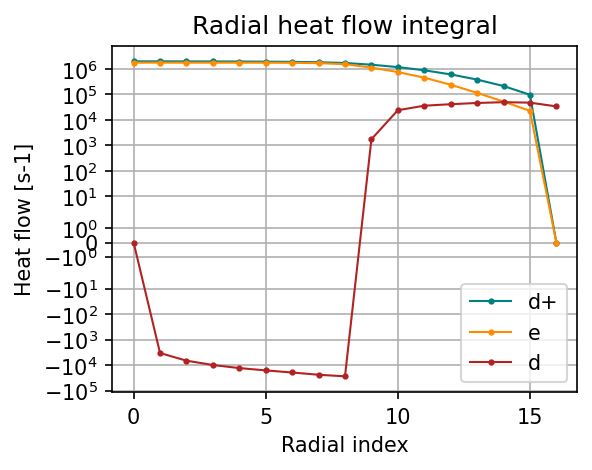

In [17]:
plot_perp_heat_fluxes(ds.isel(t=-1))

In [ ]:
impose_fields(
    source = r"/ssd_scratch/hcases/g3b1-lores_newhypno.nc",
    destination = r"/ssd_scratch/hcases/g3b1f2-mbtest.nc",
    Ni_src_core = 8.53e21,
    Pi_src_core = 1.33e6 * 2/3,
    Pe_src_core = 1.28e6 * 2/3,
    
)

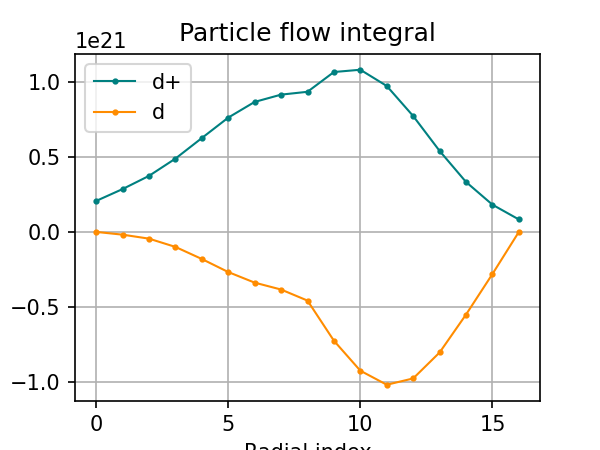

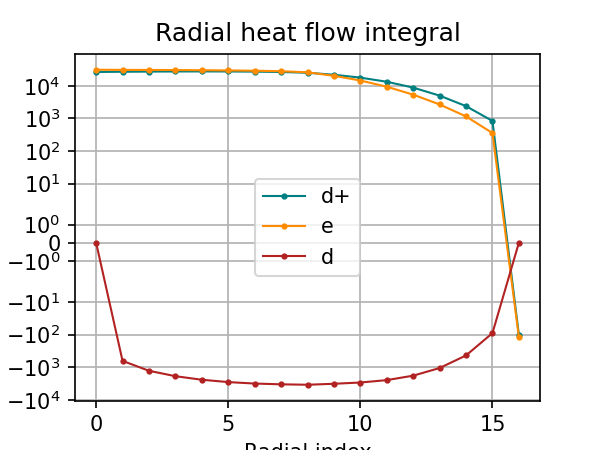

In [55]:
# plot_perp_particle_fluxes(casestore["no_neutrals"].ds.isel(t=-1))
plot_perp_particle_fluxes(casestore["free"].ds.isel(t=-1))
plot_perp_heat_fluxes(casestore["free"].ds.isel(t=-1))

In [75]:
%matplotlib widget

In [ ]:
plt.close("all")
v = viewer_2d(
    "hf_perp_tot_L_d",
    cases = {
        "st40_process" : {"code":"hermes", "ds":casestore["st40_process"].ds}
    },
    vmin = 1,
)

In [ ]:
plt.close("all")
self = Monitor2D(casestore["compasslike"], mode = "polygon", windows = [["Td", "Nd", "pf_perp_diff_d"]], 
                 settings = {
                    "all":{"view":None, "dpi": 120, "clean_guards":True},
                    "Ne":{"vmin":None, "vmax":None},
                    "Te":{"log":True, "vmin":10, "vmax":100},
                    "Td+":{"log":True, "vmin":10, "vmax":100},
                    "Nd":{"log":False, "vmax":1e18},
                    })

# Plot OMP profiles

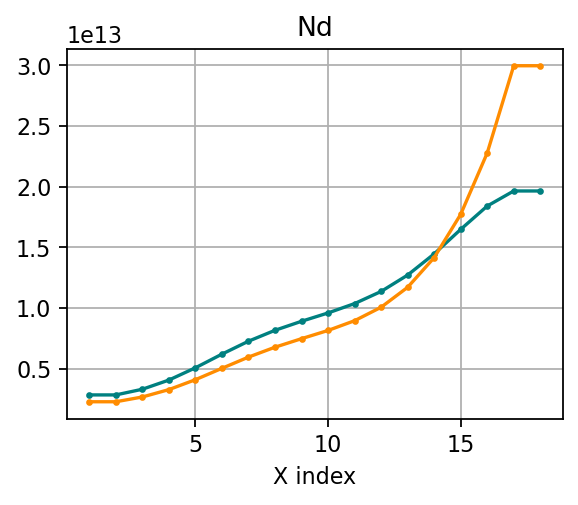

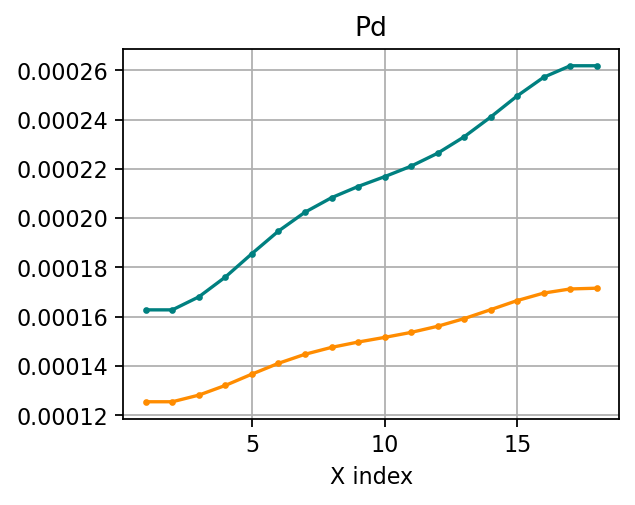

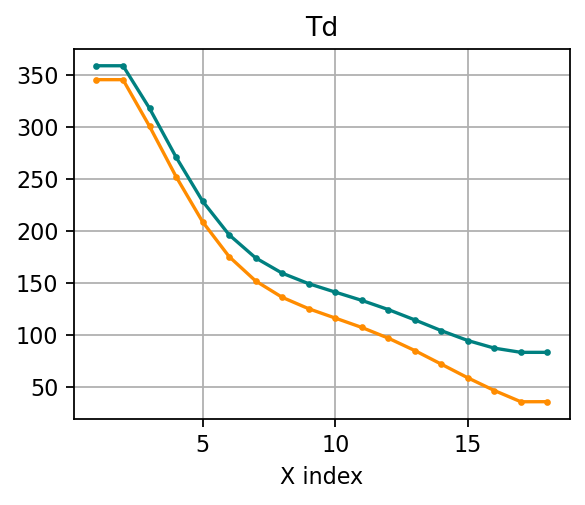

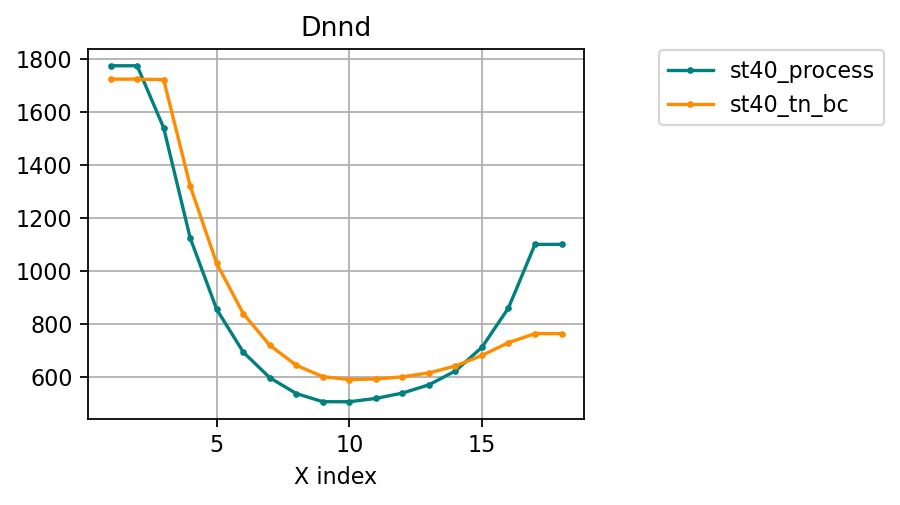

In [8]:
toplot = ["st40_process", "st40_tn_bc"]
lslist = ["-", "--", ":"]
mlist = ["o", "v", "x"]
for param in ["Nd", "Pd", "Td", "Dnnd"]:
    
    fig, ax = plt.subplots(figsize=(4,3), dpi = 160)
    for i, casename in enumerate(toplot):
        if casename != "allneumann":
            ds = casestore[casename].ds.isel(x=slice(1,-1))
            # d = ds.isel(t=-1, x=slice(2,-2)).sum("theta")
            d = ds.isel(t=-1).hermesm.select_region("outer_midplane_a")

            d[param].plot(ax = ax, marker = "o", ms = 2, c = ds.metadata["colors"][i], label = casename)

            # ax2 = ax.twinx()
            # ax2.plot(d.coords["x"], d["Sd+_iz"],  marker = "o", label = "iz (RHS)", ms = 0, c = "grey", ls = "--")

    ax.set_title(param)
    ax.set_xlabel("X index")
    ax.set_ylabel("")
    ax.grid()
fig.legend(loc = "upper left", bbox_to_anchor=(1.0, 0.9))

# Post-processing

st40_process


Exception: Plot avg_density not available

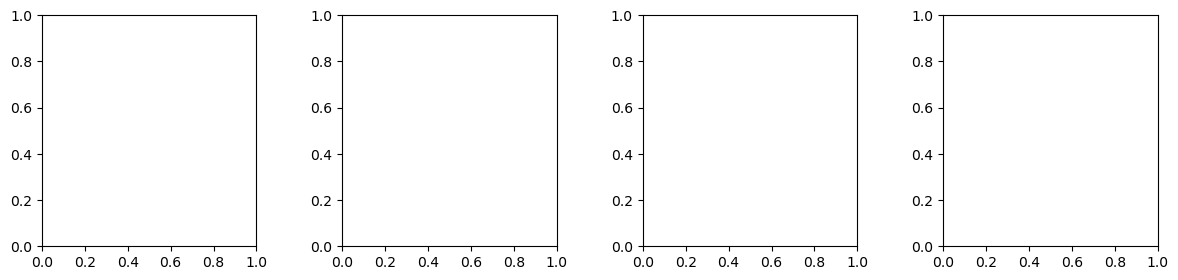

In [48]:
for casename in casestore.keys():
    print(casename)
    Monitor(casestore[casename], [["avg_density", "avg_temp", "target_temp","radiation"],
                                  ["sep_ne", "sep_te"]
                ])

{'xlim': (None, None), 'ylim': (None, None), 'figure_aspect': 0.9, 'wspace_modifier': 1, 'view': 'lower_divertor', 'dpi': 100}


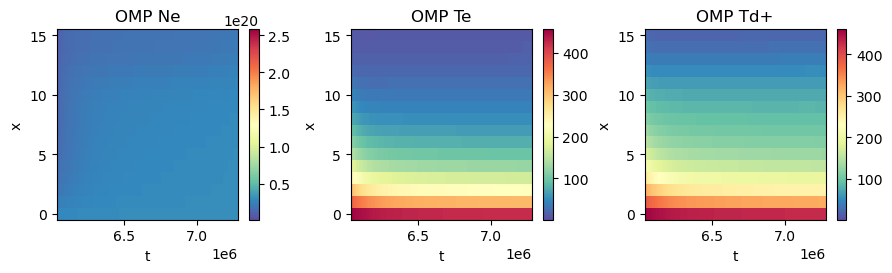

In [5]:
self = Monitor2D(caseng, mode = "omp_history", windows = [["Ne", "Te", "Td+"]], 
                 settings = {
                    "all":{"view":"lower_divertor", "dpi": 100},
                    "Ne":{"vmax":None},
                    "Te":{"vmin":None, "vmax":None},
                    "Td+":{"vmin":None, "vmax":None},
                    })

{'xlim': (None, None), 'ylim': (None, None), 'figure_aspect': 0.9, 'wspace_modifier': 1, 'view': 'None', 'dpi': 150}


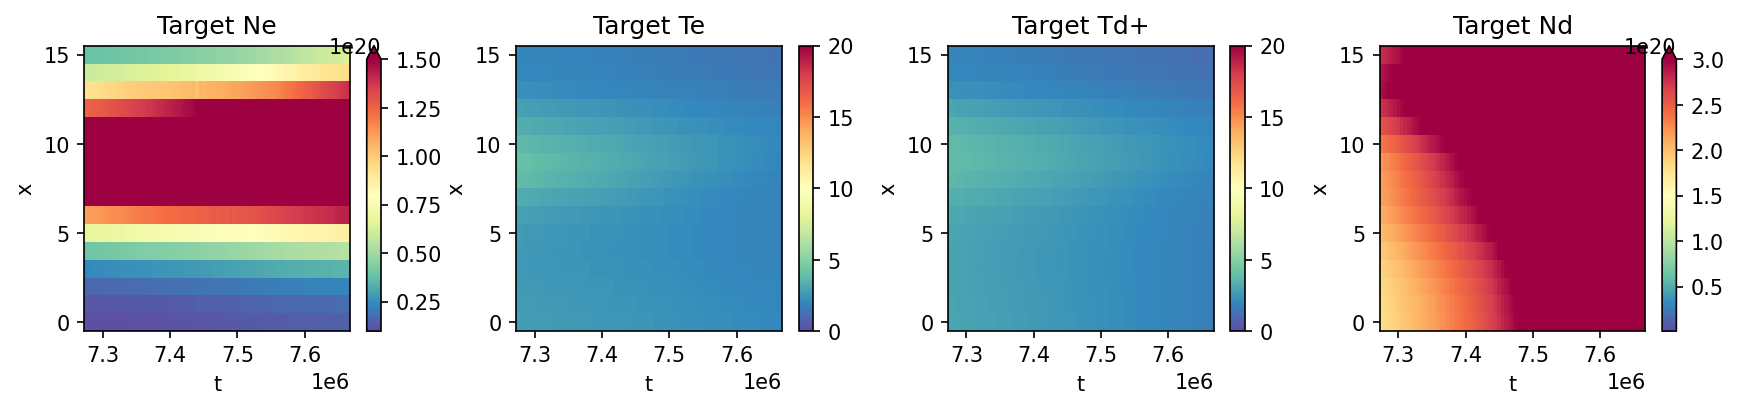

In [5]:
self = Monitor2D(caseng, mode = "target_history", windows = [["Ne", "Te", "Td+", "Nd"]], 
                 settings = {
                    "all":{"view":"None", "dpi": 150},
                    "Ne":{"vmax":15e19},
                    "Te":{"vmin":0, "vmax":20},
                    "Td+":{"vmin":0, "vmax":20},
                    "Nd":{"vmin":1e18, "vmax":3e20}
                    })

{'xlim': (None, None), 'ylim': (None, None), 'figure_aspect': 0.9, 'wspace_modifier': 1, 'view': None, 'dpi': 100}


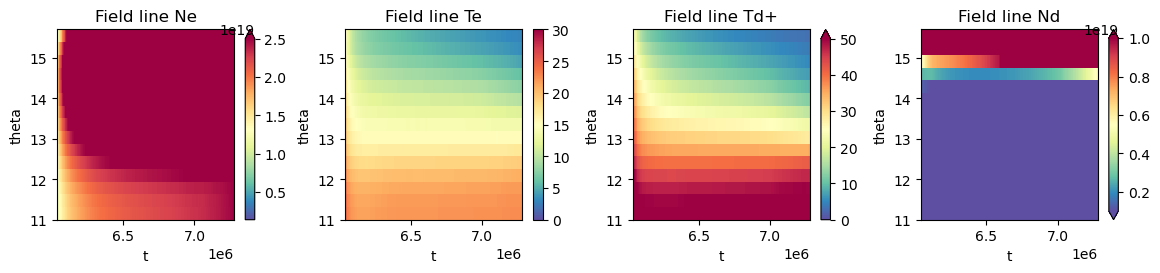

In [7]:
self = Monitor2D(caseng, mode = "field_line_history", windows = [["Ne", "Te", "Td+", "Nd"]], 
                 settings = {
                  #   "all":{"view":"lower_divertor", "dpi": 100},
                    "Ne":{"vmax":2.5e19},
                    "Te":{"vmin":0, "vmax":30},
                    "Td+":{"vmin":0, "vmax":50},
                    "Nd":{"vmin":1e18, "vmax":1e19}
                    })

In [11]:
caseng.unnormalise(unnormalise_geom=False)

--> dx, dy and J will not be unnormalised


{'xlim': (None, None), 'ylim': (None, None), 'figure_aspect': 0.9, 'wspace_modifier': 1, 'view': None, 'dpi': 100}


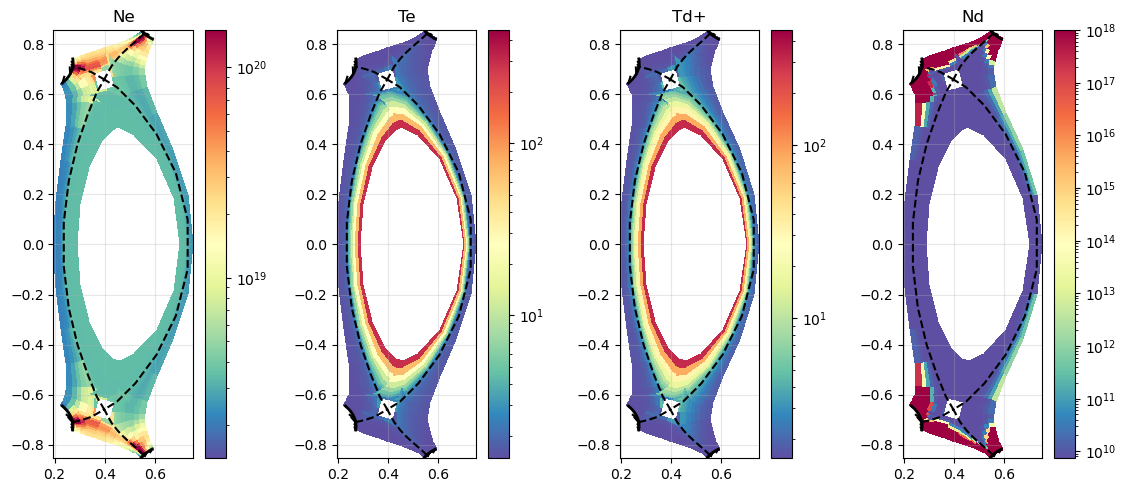

In [16]:
self = Monitor2D(caseng, mode = "pcolor", windows = [["Ne", "Te", "Td+", "Nd"]], 
                 settings = {
                    "all":{"view":None, "dpi": 100},
                    "Sd_src":{"log":False},
                    "Ne":{"vmin":None, "vmax":15e19},
                    "Te":{"log":True, "vmin":None, "vmax":None},
                    "Td+":{"log":True, "vmin":None, "vmax":None},
                    "Nd":{"log":True, "vmin":None, "vmax":1e18}
                    })